# Validation

In [1]:
# import libraries
import os
import ROOT
import numpy as np
from scipy import stats
from tableauColors import palette
from array import array
import copy

Welcome to JupyROOT 6.18/00


## 0. Helpers

In [2]:
# leakage correction
leakage = "{}*1./(1.-LateralLeakage)"

In [4]:
cal = np.load("calibration_chi.pkl.npy", allow_pickle=True).item()

In [5]:
print(cal, cal['Scnt'] / cal['Ckov'])

{'Scnt': 5.4231002679186275, 'Ckov': 0.11278347721486394, 'Chi': 0.15324425919250093} 48.08417333672975


## 1. Energy resolution as a fct of energy

In [18]:
# create rdataframe
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/range"
fileName = os.path.join(path, "range2.root")
rdf = ROOT.ROOT.RDataFrame("B4", os.path.join(path, fileName))
print(rdf.GetColumnNames())

{ "PrimaryPDG", "PrimaryEnergy", "PrimaryDecayMode", "LateralLeakage", "AbsorberMaterial", "VoxelsAlongY", "VecShowerPDG", "VecShowerCharge", "VecShowerPosition", "VecShowerEnergy", "VecShowerMomentum", "VecShowerCkovCoMi", "VecShowerCkovCoMj", "VecShowerScntCoMi", "VecShowerScntCoMj", "VecIndexCkov", "VecSignalCkov", "VecIndexScnt", "VecSignalScnt" }


In [19]:
rdf2 = rdf
rdf2 = rdf2.Define("PrimaryEnergy_GeV", "PrimaryEnergy*1e-3")
rdf2 = rdf2.Define("VecSignalScnt_corr", leakage.format("VecSignalScnt"))
rdf2 = rdf2.Define("VecSignalCkov_corr", leakage.format("VecSignalCkov"))
rdf2 = rdf2.Define("Snorm_", "Sum(VecSignalScnt_corr) / PrimaryEnergy_GeV")
rdf2 = rdf2.Define("Cnorm_", "Sum(VecSignalCkov_corr) / PrimaryEnergy_GeV")
rdf2 = rdf2.Define("VecSignalScnt_cal", f"VecSignalScnt/{cal['Scnt']}")
rdf2 = rdf2.Define("VecSignalCkov_cal", f"VecSignalCkov/{cal['Ckov']}")
rdf2 = rdf2.Define("Ssum", "Sum(VecSignalScnt_cal)")
rdf2 = rdf2.Define("Csum", "Sum(VecSignalCkov_cal)")
rdf2 = rdf2.Define("Snorm", f"Ssum / PrimaryEnergy")
rdf2 = rdf2.Define("Cnorm", f"Csum / PrimaryEnergy")
rdf2 = rdf2.Define("CoverS", "Cnorm/Snorm")
rdf2_e = rdf2.Filter("PrimaryPDG == 11", "electron")
rdf2_pi = rdf2.Filter("PrimaryPDG == -211", "pion")
rdf2_e = rdf2_e.Define("rec_energy", f"(Ssum+Csum)/2")
rdf2_pi = rdf2_pi.Define("rec_energy", f"(Ssum-{cal['Chi']}*Csum)/(1-{cal['Chi']})")
# rdf2_e = rdf2_e.Define("rmse", "abs(PrimaryEnergy-rec_energy)/PrimaryEnergy")
# rdf2_pi = rdf2_pi.Define("rmse", "abs(PrimaryEnergy-rec_energy)/PrimaryEnergy")

# print cuts report
cutsReport_e = rdf2_e.Report()
cutsReport_e.Print()
cutsReport_pi = rdf2_pi.Report()
cutsReport_pi.Print()

electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
pion      : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %


## Response linearity

In [7]:
d = {k: np.zeros(10) for k in ['Energy', 'X', 'Xerr', 'Xsigma']}
data = {'e-': {'Snorm_': copy.deepcopy(d), 'Cnorm_': copy.deepcopy(d)}}
for s,rdf in zip(['e-'], [rdf2_e]):
    unique_energies = np.unique(rdf.AsNumpy(columns=['PrimaryEnergy'])['PrimaryEnergy'])
    for i,e in enumerate(unique_energies):
        rdf3 = rdf.Filter(f"PrimaryEnergy == {e}", f"{e*1e-3} GeV")
        for c in ['Snorm_', 'Cnorm_']:
            data[s][c]['Energy'][i] = e*1e-3
            h = rdf3.Histo1D(c)
            data[s][c]['X'][i] = h.GetMean()
            data[s][c]['Xsigma'][i] = h.GetRMS()
            data[s][c]['Xerr'][i] = h.GetRMS() / np.sqrt(h.GetEntries())

In [8]:
print(data)

{'e-': {'Snorm_': {'Energy': array([ 10.000511,  20.000511,  30.000511,  40.000511,  50.000511,
        60.000511,  70.000511,  80.000511,  90.000511, 100.000511]), 'X': array([5417.67545038, 5406.19282556, 5416.87351368, 5416.36315507,
       5424.23735109, 5428.08424208, 5426.45030539, 5426.47255325,
       5433.98384291, 5436.06030159]), 'Xerr': array([8.1108084 , 6.34797583, 5.20015747, 4.6746202 , 4.45466019,
       4.48739536, 4.11991059, 3.89819954, 3.91644849, 3.93424077]), 'Xsigma': array([256.48628221, 200.74062159, 164.44341787, 147.82447027,
       140.86872408, 141.90390084, 130.28301214, 123.27189311,
       123.84897576, 124.41161691])}, 'Cnorm_': {'Energy': array([ 10.000511,  20.000511,  30.000511,  40.000511,  50.000511,
        60.000511,  70.000511,  80.000511,  90.000511, 100.000511]), 'X': array([112.81101325, 112.93882707, 112.77416954, 112.81487052,
       112.71778481, 112.84899934, 112.79928299, 112.74854924,
       112.7046075 , 112.80320442]), 'Xerr': array(

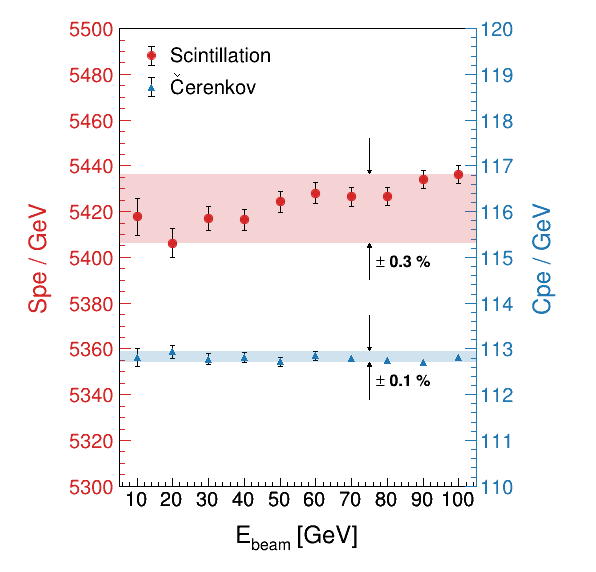

In [9]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
marker = [ROOT.kFullDotLarge, ROOT.kFullTriangleUp]

pad1 = ROOT.TPad("pad1","",0,0,1,1)
pad2 = ROOT.TPad("pad2","",0,0,1,1)
pad2.SetFillStyle(4000)
pad2.SetFrameFillStyle(0)

ratio = 1.1
ratio2 = 1.2*ratio
linewidth = 1
linespacing = 0.05

hoffset = [0.6, 0.3]

gr = [None, None]
s = 'e-'
for i,c in enumerate(['Snorm_', 'Cnorm_']):
    x = array('f', data[s][c]['Energy'])
    n = len(x)
    y = array('f', data[s][c]['X'])
    ex = array('f', [0.]*n)
    ey = array('f', data[s][c]['Xerr'])
    gr[i] = ROOT.TGraphErrors(n, x, y, ex, ey)
    gr[i].SetTitle("")
    gr[i].SetLineWidth(linewidth)
    
    
    if c == 'Snorm_':
        gr[i].GetYaxis().SetRangeUser(5300, 5500)
        pad1.Draw()
        pad1.cd()
        gr[i].Draw("PAY")
        gr[i].SetMarkerColor(palette['Scnt'].GetNumber())
        gr[i].GetYaxis().SetAxisColor(palette['Scnt'].GetNumber())
        gr[i].GetYaxis().SetLabelColor(palette['Scnt'].GetNumber())
        gr[i].GetYaxis().SetTitleColor(palette['Scnt'].GetNumber())
        gr[i].GetYaxis().SetTitle("Spe / GeV")
        gr[i].GetYaxis().CenterTitle()
        
    if c == 'Cnorm_':
        gr[i].GetYaxis().SetRangeUser(110, 120)
        pad2.Draw()
        pad2.cd()
        gr[i].SetMarkerColor(palette['Ckov'].GetNumber())
        gr[i].GetYaxis().SetAxisColor(palette['Ckov'].GetNumber())
        gr[i].GetYaxis().SetLabelColor(palette['Ckov'].GetNumber())
        gr[i].GetYaxis().SetTitleColor(palette['Ckov'].GetNumber())
        gr[i].GetYaxis().SetTitle("Cpe / GeV")
        gr[i].GetYaxis().CenterTitle()
        gr[i].Draw("PAY+")
    
    gr[i].SetMarkerStyle(marker[i])

    ROOT.gPad.SetLeftMargin(0.2)
    ROOT.gPad.SetBottomMargin(0.15)
    ROOT.gPad.SetRightMargin(0.2)
    ROOT.gPad.SetTopMargin(0.05)

    gr[i].GetXaxis().SetTitleSize(ratio2 * gr[i].GetXaxis().GetTitleSize())
    gr[i].GetYaxis().SetTitleSize(ratio2 * gr[i].GetYaxis().GetTitleSize())

    labelsize = ratio * gr[i].GetXaxis().GetLabelSize()
    gr[i].GetXaxis().SetLabelSize(labelsize)
    gr[i].GetYaxis().SetLabelSize(labelsize)

    labeloffset = ratio * gr[i].GetXaxis().GetLabelOffset()
    gr[i].GetXaxis().SetLabelOffset(labeloffset)
    gr[i].GetYaxis().SetLabelOffset(labeloffset)

    gr[i].GetXaxis().SetLimits(5., 105.)

    gr[i].GetXaxis().SetTitleOffset(ratio2 * gr[i].GetXaxis().GetTitleOffset()-0.1)
    gr[i].GetYaxis().SetTitleOffset(gr[i].GetXaxis().GetTitleOffset() + hoffset[i])

    gr[i].GetXaxis().SetTickLength(0.7 * ratio * gr[i].GetXaxis().GetTickLength())
    gr[i].GetYaxis().SetTickLength(0.7 * ratio * gr[i].GetYaxis().GetTickLength())

gr[0].GetXaxis().SetTitle("E_{beam} [GeV]")
gr[0].GetXaxis().CenterTitle()

pad1.cd()
Smin = np.min(data[s]['Snorm_']['X'])
Smax = np.max(data[s]['Snorm_']['X'])
box1 = ROOT.TBox(5., Smin, 105., Smax)
box1.SetFillColorAlpha(palette['Scnt'].GetNumber(), 0.2)
box1.Draw()

pad2.cd()
Cmin = np.min(data[s]['Cnorm_']['X'])
Cmax = np.max(data[s]['Cnorm_']['X'])
box2 = ROOT.TBox(5., Cmin, 105., Cmax)
box2.SetFillColorAlpha(palette['Ckov'].GetNumber(), 0.2)
box2.Draw()

# add legend
x1 = ROOT.gPad.GetLeftMargin()+gr[i].GetXaxis().GetTickLength()
y2 = 1-ROOT.gPad.GetTopMargin()-0.02
legend = ROOT.TLegend(x1, y2-2 * ratio * linespacing, x1+0.25, y2)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(gr[0], "Scintillation", "pe")
legend.AddEntry(gr[1], "#check{C}erenkov", "pe")
legend.Draw()

pad1.cd()
gr[0].Draw("P same")

pad1.cd()
x = 75.
ar1 = ROOT.TArrow(x, Smin-16, x, Smin, 0.01, "|>")
ar1.SetLineWidth(1)
ar1.Draw()

ar2 = ROOT.TArrow(x, Smax+16, x, Smax, 0.01, "|>")
ar2.SetLineWidth(1)
ar2.Draw()

pad2.cd()
ar3 = ROOT.TArrow(x, Cmin-0.8, x, Cmin, 0.01, "|>")
ar3.SetLineWidth(1)
ar3.Draw()

ar4 = ROOT.TArrow(x, Cmax+0.8, x, Cmax, 0.01, "|>")
ar4.SetLineWidth(1)
ar4.Draw()

pad1.cd()
t1 = ROOT.TLatex(x+2, Smin-8, f"#pm {(Smax-(Smin+Smax)/2)/((Smin+Smax)/2)*100:.1g} %")
t1.SetTextAlign(12)
t1.SetTextSize(0.8*labelsize)
t1.Draw()

pad2.cd()
t2 = ROOT.TLatex(x+2, Cmin-0.4, f"#pm {(Cmax-(Cmin+Cmax)/2)/((Cmin+Cmax)/2)*100:.1g} %")
t2.SetTextAlign(12)
t2.SetTextSize(0.8*labelsize)
t2.Draw()

c1.Update()
c1.Modified()
c1.Draw()
c1.Print("linearity.png")

In [10]:
Ssigma = 1/np.sum(1/data[s]['Snorm_']['Xsigma']**2)
Smean = Ssigma*np.sum(data[s]['Snorm_']['X']/data[s]['Snorm_']['Xsigma']**2)
Ssigma = np.sqrt(Ssigma)

Csigma = 1/np.sum(1/data[s]['Cnorm_']['Xsigma']**2)
Cmean = Csigma*np.sum(data[s]['Cnorm_']['X']/data[s]['Cnorm_']['Xsigma']**2)
Csigma = np.sqrt(Csigma)

print(f"{Smean:.0f} +/- {Ssigma:.0f}")
print(f"{Cmean:.0f} +/- {Csigma:.0f}")

5426 +/- 46
113 +/- 1


In [27]:
np.mean(rdf2_e.AsNumpy(["Snorm_"])["Snorm_"]), np.std(rdf2_e.AsNumpy(["Snorm_"])["Snorm_"])

(numpy.array(5423.2393541), numpy.array(160.83447363))

In [25]:
np.mean(rdf2_e.AsNumpy(["Cnorm_"])["Cnorm_"]), np.std(rdf2_e.AsNumpy(["Cnorm_"])["Cnorm_"])

(numpy.array(112.79613087), numpy.array(3.54406828))

In [11]:
print(data[s]['Snorm_']['Xsigma'])

[256.48628221 200.74062159 164.44341787 147.82447027 140.86872408
 141.90390084 130.28301214 123.27189311 123.84897576 124.41161691]


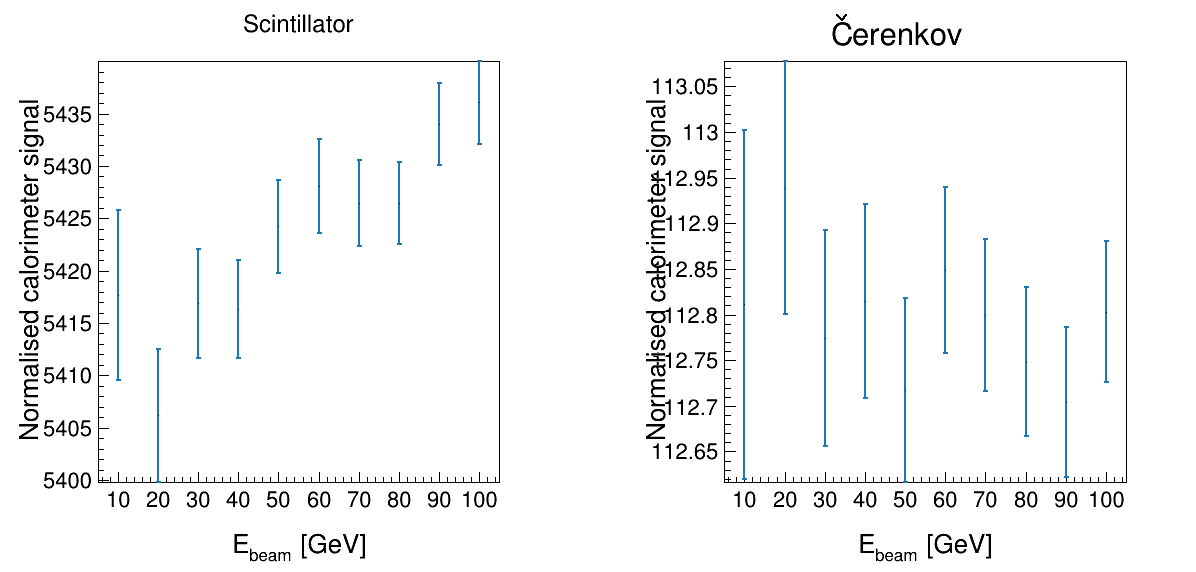

In [19]:
c1 = ROOT.TCanvas("c1", "c1", 1200, 600)
c1.Divide(2)
mg = [None, None]
# marker = [ROOT.kFullDotLarge, ROOT.kFullTriangleUp]

ratio = 1.2
ratio2 = 1.2*ratio
linewidth = 2
x2ndc = 0.80+0.05
x1ndc = x2ndc-0.5
y2ndc = 0.88+0.05
linespacing = 0.05
title = ["Scintillator", "#check{C}erenkov"]

for j,c in enumerate(['Snorm_', 'Cnorm_']):
    c1.cd(j+1)
    mg[j] = ROOT.TMultiGraph()
    gr = [None, None]
    if j == 0:
        ROOT.gPad.SetLeftMargin(0.15)
        ROOT.gPad.SetRightMargin(0.15)
    else:
        ROOT.gPad.SetLeftMargin(0.2)
        ROOT.gPad.SetRightMargin(0.1)
    ROOT.gPad.SetBottomMargin(0.15)
    ROOT.gPad.SetTopMargin(0.1)
    for i,s in enumerate(['e-']):
        x = array('f', data[s][c]['Energy'])
        n = len(x)
        y = array('f', data[s][c]['X'])
        ex = array('f', [0.]*n)
        ey = array('f', data[s][c]['Xerr'])
        gr[i] = ROOT.TGraphErrors(n, x, y, ex, ey)
    #     gr[i].Fit(f1[i], "S")
    #     gr[i].SetMarkerStyle(marker[i])
        gr[i].SetLineColor(palette[s].GetNumber())
        gr[i].SetLineWidth(linewidth)
        mg[j].Add(gr[i])

    mg[j].SetTitle(title[j])
#     mg[j].GetTitle().SetTitleOffset(0.01)
    
    mg[j].GetXaxis().SetTitle("E_{beam} [GeV]")
    mg[j].GetYaxis().SetTitle("Normalised calorimeter signal")
    
    mg[j].GetXaxis().SetTitleSize(ratio2 * mg[j].GetXaxis().GetTitleSize())
    mg[j].GetYaxis().SetTitleSize(ratio2 * mg[j].GetYaxis().GetTitleSize())

    labelsize = ratio * mg[j].GetXaxis().GetLabelSize()
    mg[j].GetXaxis().SetLabelSize(labelsize)
    mg[j].GetYaxis().SetLabelSize(labelsize)

    labeloffset = (ratio + 1) * mg[j].GetXaxis().GetLabelOffset()
    mg[j].GetXaxis().SetLabelOffset(labeloffset)
    mg[j].GetYaxis().SetLabelOffset(labeloffset)
    
    mg[j].GetXaxis().CenterTitle()
    mg[j].GetYaxis().CenterTitle()
    
#     mg[j].SetMaximum(1.1)
#     mg[j].SetMinimum(0.4)
    mg[j].GetXaxis().SetLimits(5., 105.)
    
    mg[j].GetXaxis().SetTitleOffset(ratio2 * mg[j].GetXaxis().GetTitleOffset())
    mg[j].GetYaxis().SetTitleOffset(mg[j].GetXaxis().GetTitleOffset())

    mg[j].GetXaxis().SetTickLength(0.7 * ratio * mg[j].GetXaxis().GetTickLength())
    mg[j].GetYaxis().SetTickLength(0.7 * ratio * mg[j].GetYaxis().GetTickLength())

    mg[j].Draw('ap')
    
c1.Draw()

0.0014981393717644984


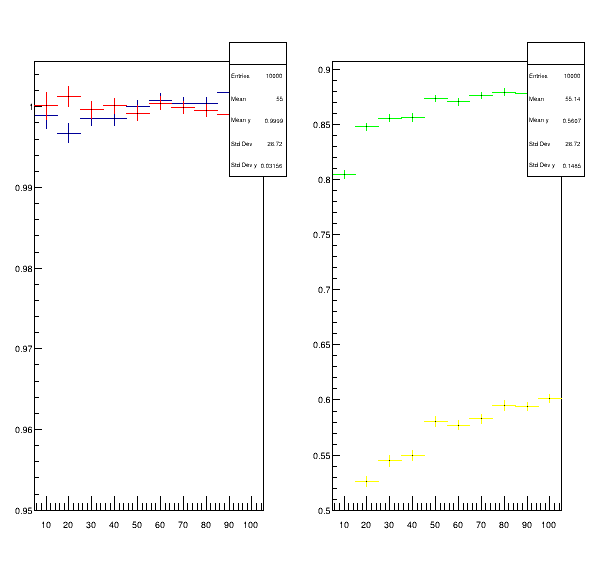

In [135]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
c1.Divide(2)
xlow = 5
xup = 105
nbins = 10
model = ("", "", nbins, xlow, xup)
h1 = rdf2_e.Profile1D(model, "PrimaryEnergy_GeV", "Snorm")
print(h1.GetBinError(1))
h3 = rdf2_pi.Profile1D(model, "PrimaryEnergy_GeV", "Snorm")
h2 = rdf2_e.Profile1D(model, "PrimaryEnergy_GeV", "Cnorm")
h4 = rdf2_pi.Profile1D(model, "PrimaryEnergy_GeV", "Cnorm")
c1.cd(1)
h1.Draw("HIST p e")
h2.Draw("sames")
h2.SetLineColor(ROOT.kRed)
h1.SetMinimum(1.05)
h1.SetMinimum(0.95)

c1.cd(2)
h3.Draw()
h4.Draw("sames")
h3.SetLineColor(ROOT.kGreen)
h4.SetLineColor(ROOT.kYellow)
h3.SetMinimum(1.1)
h3.SetMinimum(0.5)
c1.Draw()

In [20]:
import copy
ROOT.gStyle.SetOptStat("emr")
d = {k: np.zeros(10) for k in ['Energy', 'EnergyRes', 'EnergyResErr']}
data = {'e': copy.deepcopy(d), 'pi': copy.deepcopy(d)}
c1 = {'e': None, 'pi': None}
# model = {'e': ("", "", 600, 0., 120.), 'pi': ("", "", 240, 0., 120.)}
for rdf,s in zip([rdf2_e, rdf2_pi], ['e', 'pi']):
#     c1[s] = ROOT.TCanvas("c1"+s, "c1"+s, 1200, 1200)
#     c1[s].Divide(3,3)
#     unique_energies = np.unique(rdf.AsNumpy(columns=['PrimaryEnergy'])['PrimaryEnergy'])
    for i,e in enumerate(range(10,110,10)):
#         c1[s].cd(i+1)
#         rdf3 = rdf.Filter(f"PrimaryEnergy == {e}", f"{e*1e-3} GeV")
#         rdf3 = rdf3.Filter(modifiedZscore(rdf3, "rec_energy"), "modified Z-score")
#         cutsReport = rdf3.Report()
#         cutsReport.Print()
        res, reserr = plot_energyres(rdf, s, e)
        
#         h = rdf3.Histo1D(model[s], 'rec_energy')
#         r = h.Fit("gaus", "S")
        data[s]['Energy'][i] = e
#         data[s]['EnergyRes'][i] = r.Parameter(2)/r.Parameter(1)*1e2
        data[s]['EnergyRes'][i] = res
#         data[s]['EnergyResErr'][i] = data[s]['EnergyRes'][i]*(r.ParError(1)/r.Parameter(1)+r.ParError(2)/r.Parameter(2))
        data[s]['EnergyResErr'][i] = reserr
#         h.DrawCopy()

electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
10 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
 FCN=11.3111 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=7.60636e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.82256e+02   7.09254e+00   9.93272e-03   3.48747e-05
   2  Mean         9.97965e+00   1.39648e-02   2.37703e-05  -2.11656e-02
   3  Sigma        4.33322e-01   9.84493e-03   1.00188e-05   4.65567e-02
electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
10 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
 FCN=10.9988 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=6.07207e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
 

 FCN=4.90817 FROM MIGRAD    STATUS=CONVERGED      34 CALLS          35 TOTAL
                     EDM=6.83523e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.24525e+00   3.22577e-01   1.21709e-04  -3.10147e-10
   2  p1           3.39080e-01   4.71530e-02   1.77908e-05   3.74425e-10
 FCN=7.48717 FROM MIGRAD    STATUS=CONVERGED      38 CALLS          39 TOTAL
                     EDM=1.57023e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.04277e+01   1.44717e+00   6.43377e-04  -1.20793e-10
   2  p1           2.47444e+00   2.09168e-01   9.29910e-05  -1.59983e-09


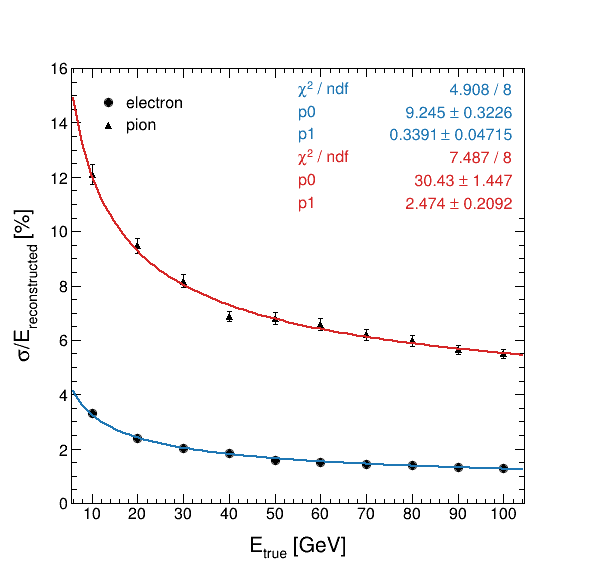

In [21]:
ROOT.gStyle.SetOptStat("emr")
ROOT.gStyle.SetOptFit(1)

c2 = ROOT.TCanvas("c2", "c2", 600, 600)
c2.SetLeftMargin(.12)
c2.SetBottomMargin(.12)
c2.SetRightMargin(.12)
c2.SetTopMargin(.12)

mg = ROOT.TMultiGraph()
gr = [None, None]
f1 = [None, None]
f1[0] = ROOT.TF1("f1","[0]/sqrt(x)+[1]")
f1[1] = f1[0].Clone()
f1[0].SetLineColor(palette['blue'].GetNumber())
f1[1].SetLineColor(palette['red'].GetNumber())
marker = [ROOT.kFullDotLarge, ROOT.kFullTriangleUp]


for i,s in enumerate(['e', 'pi']):
    x = array('f', data[s]['Energy'])
    n = len(x)
    y = array('f', data[s]['EnergyRes'])
    ex = array('f', [0.]*n)
    ey = array('f', data[s]['EnergyResErr'])
    gr[i] = ROOT.TGraphErrors(n, x, y, ex, ey)
    gr[i].Fit(f1[i], "S")
    gr[i].SetMarkerStyle(marker[i])
    
    mg.Add(gr[i])
mg.Draw('ap')

c2.Update()

labelsize = 0.03
titlesize = 0.04
titleoffset = 1.2
labeloffset = 0.005
linewidth = 3
ticklength = 0.02

mg.GetXaxis().SetTitle("E_{true} [GeV]")
mg.GetYaxis().SetTitle("#sigma/E_{reconstructed} [%]")
mg.SetMinimum(0.)
mg.SetMaximum(16.)
mg.GetXaxis().SetTickLength(ticklength)
mg.GetYaxis().SetTickLength(ticklength)
mg.GetXaxis().SetTitleSize(titlesize)
mg.GetYaxis().SetTitleSize(titlesize)
mg.GetXaxis().SetLabelSize(labelsize)
mg.GetYaxis().SetLabelSize(labelsize)
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.GetXaxis().SetTitleOffset(titleoffset)
mg.GetYaxis().SetTitleOffset(titleoffset)
mg.GetXaxis().SetLabelOffset(labeloffset)
mg.GetYaxis().SetLabelOffset(labeloffset)

stats1 = gr[0].GetListOfFunctions().FindObject("stats")
stats2 = gr[1].GetListOfFunctions().FindObject("stats")
stats1.SetTextColor(palette['blue'].GetNumber())
stats2.SetTextColor(palette['red'].GetNumber())
stats1.SetX2NDC(1-c2.GetRightMargin()); stats1.SetX1NDC(stats1.GetX2NDC()-0.4)
stats1.SetY2NDC(1-c2.GetTopMargin()-0.016); stats1.SetY1NDC(stats1.GetY2NDC()-0.12)
stats2.SetX2NDC(stats1.GetX2NDC()); stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY2NDC(stats1.GetY1NDC()); stats2.SetY1NDC(stats2.GetY2NDC()-0.12)
stats1.SetTextSize(labelsize)
stats2.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats2.SetBorderSize(0)

# add legend
x1 = c2.GetLeftMargin() + 0.03
x2 = x1 + 0.25
y2 = 1 - c2.GetTopMargin() - 0.03 - 0.01
y1 = y2 - 0.08
legend = ROOT.TLegend(x1, y1, x2, y2)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(gr[0], "electron", "p")
legend.AddEntry(gr[1], "pion", "p")
legend.Draw()

c2.SetTicks(1, 1)

c2.Modified()
c2.Print("energyres.png")
c2.Draw()

## 2. Example for 80 GeV

In [11]:
def plot_energyres(rdf, s, e):
    ROOT.gStyle.SetOptStat("e")
    ROOT.gStyle.SetOptFit(1)
    c3 = ROOT.TCanvas("c3", "c3", 1200, 600)
    c3.Divide(3)
    h = [None, None, None]
    r = h.copy()

    labelsize = 0.03*7/4
    titlesize = 0.04*7/4
    xtitleoffset = 0.8
    ytitleoffset = 1.3
    xlabeloffset = -0.006
    ylabeloffset = 0.01
    linewidth = 2
    ticklength = 0.02
    color = [palette['blue'].GetNumber(), palette['red'].GetNumber(), palette['green'].GetNumber()]

    rdf2_80_ = {}

#     for rdf,s in zip([rdf2_e, rdf2_pi], ['e', 'pi']):
    
    xlow = 0.
    xup = e+20.
    nbins = {'e': int((xup-xlow)/0.2), 'pi': int((xup-xlow)/0.5)}
    model = ("", "", nbins[s], xlow, xup)

    rdf2_80 = rdf.Filter(f"std::round(PrimaryEnergy*1E-3) == {e}", f"{e} GeV")
    colname = ["Scintillating signal", "#check{C}erenkov signal", "Reconstructed energy"]
    for i,col in enumerate(['Ssum', 'Csum', 'rec_energy']):
        c3.cd(i+1)
        new_col = col + "_GeV"
        rdf2_80 = rdf2_80.Define(new_col, f"{col}*1e-3")
        rdf2_80_[s] = rdf2_80 #.Filter(modifiedZscore(rdf2_80, new_col), "modified Z-score")
        cutsReport = rdf2_80_[s].Report()
        cutsReport.Print()
#         if s == 'e':
#             continue
#         model = ("", "", 200, 0., 100.)
        h[i] = rdf2_80_[s].Histo1D(model, new_col)
        r[i] = h[i].Fit("gaus", "S")

        h[i].GetXaxis().SetTitle(colname[i] + " [GeV]")
        h[i].SetAxisRange(0., 80., "Y")
        h[i].GetXaxis().SetTickLength(ticklength)
        h[i].GetYaxis().SetTickLength(ticklength)
        h[i].GetXaxis().SetTitleSize(titlesize)
        h[i].GetYaxis().SetTitleSize(titlesize)
        h[i].GetXaxis().SetLabelSize(labelsize)
        h[i].GetYaxis().SetLabelSize(labelsize)
        h[i].GetXaxis().CenterTitle()
        h[i].GetXaxis().SetTitleOffset(xtitleoffset)
        h[i].GetXaxis().SetLabelOffset(xlabeloffset)

        ROOT.gPad.SetTopMargin(.02)
        ROOT.gPad.SetBottomMargin(.18)

        if i == 0:
            h[i].GetYaxis().SetTitle(f"Events / {h[i].GetBinWidth(0):.1g} GeV")
            h[i].GetYaxis().CenterTitle()
            h[i].GetYaxis().SetTitleOffset(ytitleoffset)
            h[i].GetYaxis().SetLabelOffset(ylabeloffset)
            ROOT.gPad.SetLeftMargin(.18)
            ROOT.gPad.SetRightMargin(.04)
        else:
            h[i].GetYaxis().SetLabelOffset(999)
            h[i].GetYaxis().SetLabelSize(0)
        if i == 1: 
            ROOT.gPad.SetLeftMargin(.11)
            ROOT.gPad.SetRightMargin(.11)
        if i == 2:
            ROOT.gPad.SetLeftMargin(.04)
            ROOT.gPad.SetRightMargin(.18)

        h[i].Draw()
        h[i].SetLineWidth(1)
        h[i].SetLineColor(ROOT.kBlack)
        f1 = h[i].GetListOfFunctions().FindObject("gaus")
        f1.SetLineColor(color[i])
        f1.SetLineWidth(linewidth)

        c3.Update()

        stats1 = ROOT.gPad.GetPrimitive("stats")
        stats1.SetName("stats1")
        listOfLines1 = stats1.GetListOfLines()

        res = r[i].Parameter(2)/r[i].Parameter(1)
        reserr = res*(r[i].ParError(1)/r[i].Parameter(1)+r[i].ParError(2)/r[i].Parameter(2))

        myt1 = ROOT.TLatex(0, 0, f"#sigma/#mu = {res:.3f} #pm {reserr:.3f}")
        myt1.SetTextSize(labelsize)
        myt1.SetTextFont(42)
        myt1.SetTextColor(ROOT.kBlack)
        listOfLines1.First().SetTextColor(ROOT.kBlack)
        listOfLines1.Add(myt1)
        stats1.SetTextColor(color[i])
        stats1.SetX1NDC(ROOT.gPad.GetLeftMargin()+0.005); stats1.SetX2NDC(stats1.GetX1NDC()+0.53)
        stats1.SetY2NDC(1-ROOT.gPad.GetTopMargin()-0.01); stats1.SetY1NDC(stats1.GetY2NDC()-0.3)
        stats1.SetTextSize(labelsize)
        stats1.SetBorderSize(0)
        h[i].SetStats(0)

    c3.Draw()
    c3.Print(f"energyres_{s}_{e}GeV.png")
    return res*1e2, reserr*1e2

In [61]:
# plot_energyres(rdf2_pi, 'pi', 80)

(5.75970602536948, 0.19688172199930062)

pion      : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
80 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=975        all=1000       -- eff=97.50 % cumulative eff=4.88 %
 FCN=45.1268 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=8.81543e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.71409e+01   1.57224e+00   4.03864e-03  -1.74498e-04
   2  Mean         7.13507e+01   1.66789e-01   5.49929e-04  -3.27333e-03
   3  Sigma        5.00577e+00   1.36942e-01   2.26918e-05  -1.48236e-01
pion      : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
80 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=989        all=1000       -- eff=98.90 % cumulati

### C/E vs. S/E

In [8]:
e = 80
rdf2_80_ = {}
for rdf,s in zip([rdf2_e, rdf2_pi], ['e', 'pi']):
    rdf2_80 = rdf.Filter(f"std::round(PrimaryEnergy*1E-3) == {e}", f"{e} GeV")
#     colname = ["Scintillating signal", "#check{C}erenkov signal", "Reconstructed energy"]
    for i,col in enumerate(['Ssum', 'Csum', 'rec_energy']):
#         c3.cd(i+1)
        new_col = col + "_GeV"
        rdf2_80 = rdf2_80.Define(new_col, f"{col}*1e-3")
        rdf2_80_[s] = rdf2_80.Filter(modifiedZscore(rdf2_80, new_col), "modified Z-score")
        cutsReport = rdf2_80_[s].Report()
        cutsReport.Print()

electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
80 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=997        all=1000       -- eff=99.70 % cumulative eff=4.99 %
electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
80 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=999        all=1000       -- eff=99.90 % cumulative eff=4.99 %
electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
80 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=992        all=1000       -- eff=99.20 % cumulative eff=4.96 %
pion      : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
80 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=975        all=1000       -- eff=97.50 % cumulative eff=4.88 %
pion      : 

In [9]:
# correlation coefficients
SC_e = rdf2_80_['e'].AsNumpy(columns=["Snorm", "Cnorm"])
SC_pi = rdf2_80_['pi'].AsNumpy(columns=["Snorm", "Cnorm"])
print(stats.pearsonr(x=SC_e['Snorm'], y=SC_e['Cnorm']))
print(stats.pearsonr(x=SC_pi['Snorm'], y=SC_pi['Cnorm']))

(-0.15250941881221836, 1.3955410747420188e-06)
(0.7366006372782073, 6.215157479739005e-167)


In [10]:
gr1 = rdf2_80_['e'].Graph("Snorm", "Cnorm")
gr2 = rdf2_80_['pi'].Graph("Snorm", "Cnorm")
# r = gr2.Fit("pol1", "S")
# gr3 = rdf4.Graph("Snorm_rot", "Cnorm_rot")
gr1.SetMarkerColor(palette['blue'].GetNumber())
gr2.SetMarkerColor(palette['red'].GetNumber())
gr1.SetMarkerStyle(ROOT.kFullDotSmall)
gr2.SetMarkerStyle(ROOT.kFullDotSmall)

In [22]:
unique_energies = np.unique(rdf2_80_['pi'].AsNumpy(columns=['PrimaryEnergy'])['PrimaryEnergy'])
print(unique_energies)

[80139.5701]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Info in <TCanvas::Print>: png file hSC.png has been created


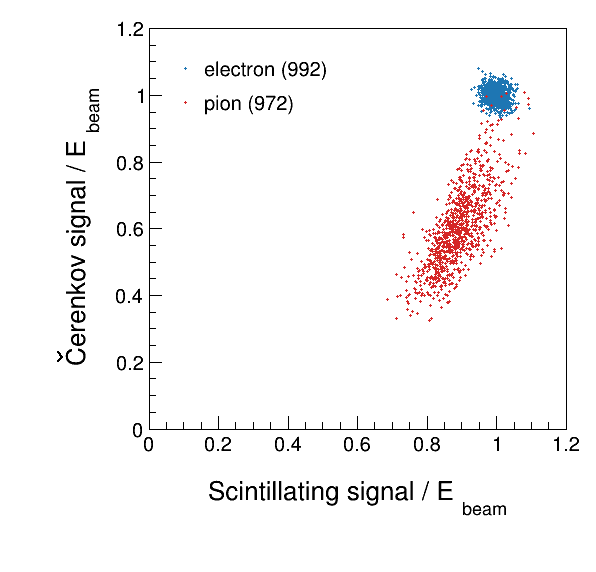

In [20]:
ratio = 5/4
c4 = ROOT.TCanvas("c4", "c4", 600, 600)
c4.SetLeftMargin(0.25)
c4.SetRightMargin(0.05)
c4.SetBottomMargin(0.25)
c4.SetTopMargin(0.05)
mg = ROOT.TMultiGraph()
mg.Add(gr1.GetPtr())
mg.Add(gr2.GetPtr())
# mg.Add(gr3.GetPtr())
mg.Draw("ap")

labelsize = 0.03 * ratio
titlesize = 0.04 * ratio
titleoffset = 1.2 * ratio
labeloffset = 0.005 * ratio * 1.5
linewidth = 3
ticklength = 0.03

mg.GetXaxis().SetTitle("Scintillating signal / E_{beam}")
mg.GetYaxis().SetTitle("#check{C}erenkov signal / E_{beam}")
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.SetMinimum(0)
mg.SetMaximum(1.2)
mg.GetXaxis().SetLimits(0, 1.2)
mg.GetXaxis().SetTickLength(ticklength)
mg.GetYaxis().SetTickLength(ticklength)
mg.GetXaxis().SetLabelSize(labelsize)
mg.GetYaxis().SetLabelSize(labelsize)
mg.GetXaxis().SetTitleSize(titlesize)
mg.GetYaxis().SetTitleSize(titlesize)
mg.GetXaxis().SetTitleOffset(titleoffset)
mg.GetYaxis().SetTitleOffset(titleoffset)
mg.GetXaxis().SetLabelOffset(labeloffset)
mg.GetYaxis().SetLabelOffset(labeloffset)

gr1.SetMarkerStyle(6)
gr2.SetMarkerStyle(6)
# 

# add legend
x1 = c4.GetLeftMargin() + 0.03
x2 = x1 + 0.25
y2 = 1 - c4.GetTopMargin() - 0.03 - 0.01
y1 = y2 - 0.12
legend = ROOT.TLegend(x1, y1, x2, y2)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(gr1.GetValue(), f"Electron", "p")
legend.AddEntry(gr2.GetValue(), f"Pion", "p")
legend.Draw()

# legend2 = ROOT.TPaveStats(x1, y1-0.12, x2, y1)
# myt1 = ROOT.TLatex(0, 0, f"Entries = {gr1.GetN()}")
# legend2.GetListOfLines().Add(myt1)
# legend2.Draw()

c4.Draw()
c4.Print("hSC.png")

In [ ]:
ratio = 5/4
c4 = ROOT.TCanvas("c4", "c4", 600, 600)
c4.SetLeftMargin(0.25)
c4.SetRightMargin(0.05)
c4.SetBottomMargin(0.25)
c4.SetTopMargin(0.05)
mg = ROOT.TMultiGraph()
mg.Add(gr1.GetPtr())
mg.Add(gr2.GetPtr())
# mg.Add(gr3.GetPtr())
mg.Draw("ap")

labelsize = 0.03 * ratio
titlesize = 0.04 * ratio
titleoffset = 1.2 * ratio
labeloffset = 0.005 * ratio * 1.5
linewidth = 3
ticklength = 0.03

mg.GetXaxis().SetTitle("Scintillating signal / E_{beam}")
mg.GetYaxis().SetTitle("#check{C}erenkov signal / E_{beam}")
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.SetMinimum(0)
mg.SetMaximum(1.2)
mg.GetXaxis().SetLimits(0, 1.2)
mg.GetXaxis().SetTickLength(ticklength)
mg.GetYaxis().SetTickLength(ticklength)
mg.GetXaxis().SetLabelSize(labelsize)
mg.GetYaxis().SetLabelSize(labelsize)
mg.GetXaxis().SetTitleSize(titlesize)
mg.GetYaxis().SetTitleSize(titlesize)
mg.GetXaxis().SetTitleOffset(titleoffset)
mg.GetYaxis().SetTitleOffset(titleoffset)
mg.GetXaxis().SetLabelOffset(labeloffset)
mg.GetYaxis().SetLabelOffset(labeloffset)

gr1.SetMarkerStyle(6)
gr2.SetMarkerStyle(6)
# 

# add legend
x1 = c4.GetLeftMargin() + 0.03
x2 = x1 + 0.25
y2 = 1 - c4.GetTopMargin() - 0.03 - 0.01
y1 = y2 - 0.12
legend = ROOT.TLegend(x1, y1, x2, y2)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(gr1.GetValue(), f"Electron", "p")
legend.AddEntry(gr2.GetValue(), f"Pion", "p")
legend.Draw()

# legend2 = ROOT.TPaveStats(x1, y1-0.12, x2, y1)
# myt1 = ROOT.TLatex(0, 0, f"Entries = {gr1.GetN()}")
# legend2.GetListOfLines().Add(myt1)
# legend2.Draw()

c4.Draw()
c4.Print("hSC.png")

## Rotation method

In [67]:
rdf4 = rdf2_80_['pi']
gr = rdf4.Graph("Snorm", "Cnorm")
# linear fit
r = gr.Fit("pol1", "S")


****************************************
Minimizer is Linear
Chi2                      =      6.32978
NDf                       =          970
p0                        =    -0.605936   +/-   0.0357328   
p1                        =      1.35663   +/-   0.0399945   


In [68]:
p0 = r.Parameter(0)
p1 = r.Parameter(1)
X = p0/(1-p1)
theta = np.pi/2 - np.arctan(p1)
print(p0, p1, X, theta*180/np.pi)

-0.6059358731426843 1.3566286657557158 1.6990666520277407 36.394721247610924


In [63]:
rotate_xcoord_code = '''
double rotate_xcoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return x;
};
'''
ROOT.gInterpreter.Declare(rotate_xcoord_code)
rotate_ycoord_code = '''
double rotate_ycoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return y;
};
'''
ROOT.gInterpreter.Declare(rotate_ycoord_code)

True

In [69]:
rdf4 = rdf4.Define("PivotPoint", str(X))
rdf4 = rdf4.Define("PivotAngle", str(theta))
rdf4 = rdf4.Define("Snorm_rot", "rotate_xcoord(Snorm, Cnorm, PivotAngle, PivotPoint)")
rdf4 = rdf4.Define("Cnorm_rot", "rotate_ycoord(Snorm, Cnorm, PivotAngle, PivotPoint)")

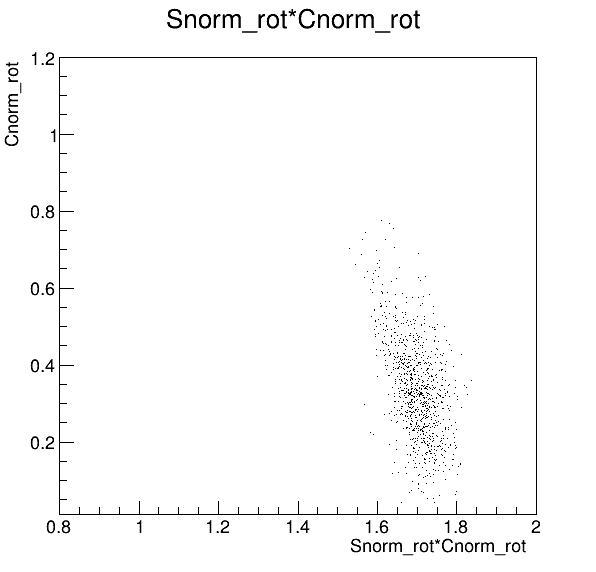

In [75]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = rdf4.Graph("Snorm_rot", "Cnorm_rot")
gr.GetXaxis().SetLimits(0.8, 2.0)
gr.SetMaximum(1.2)
gr.Draw("ap")
c1.Draw()

 FCN=61.8666 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=1.39618e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.80577e+01   1.65799e+00   4.88488e-03  -4.48600e-05
   2  Mean         1.69940e+00   1.60346e-03   5.96053e-06  -6.64145e-02
   3  Sigma        4.57085e-02   1.33448e-03   2.72845e-05  -2.08180e-02


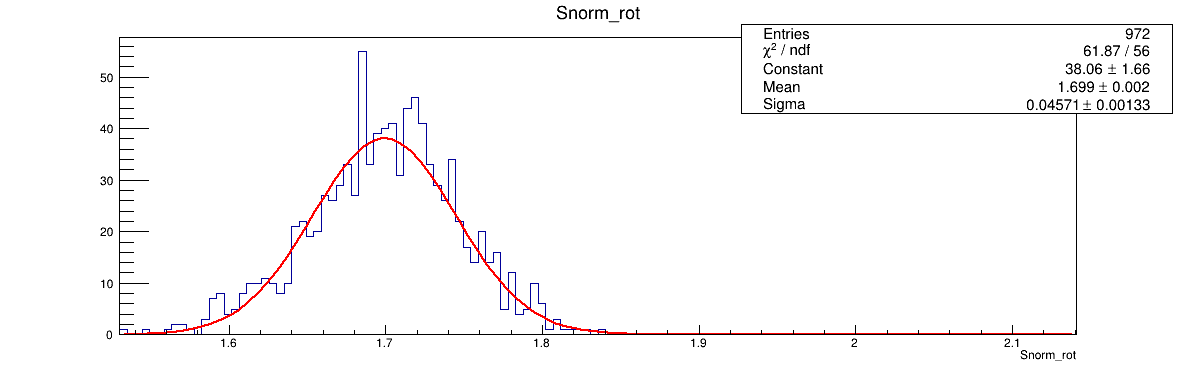

In [71]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf4.Histo1D("Snorm_rot")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

 FCN=40.7669 FROM MIGRAD    STATUS=CONVERGED      68 CALLS          69 TOTAL
                     EDM=2.66652e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.91964e+01   1.66958e+00   4.05262e-03   2.20760e-04
   2  Mean         8.90945e-01   2.07436e-03   6.48571e-06   1.43949e-01
   3  Sigma        6.22116e-02   1.72245e-03   2.17885e-05  -4.51656e-02


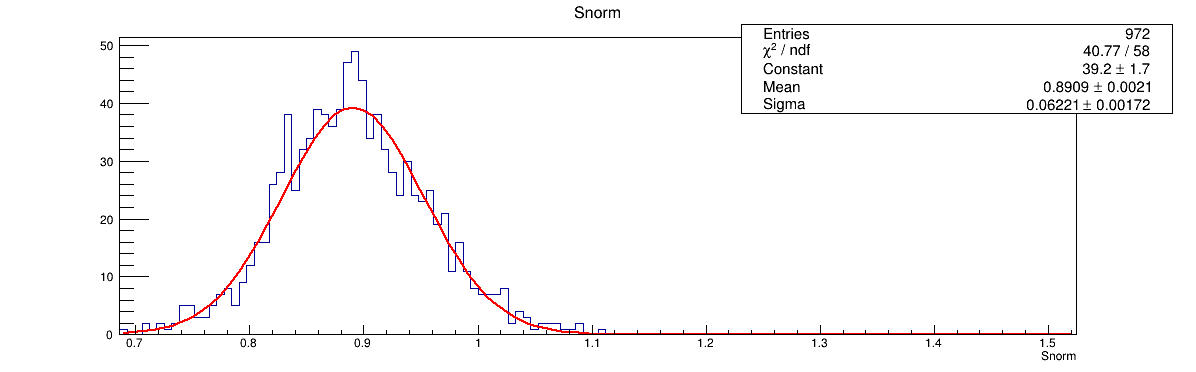

In [82]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf4.Histo1D("Snorm")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

## Energy resolution

In [7]:
c2 = ROOT.TCanvas("c1", "c1", 1000, 600)
c2.Divide(3)
ROOT.gStyle.SetOptStat("mr")
modelX = ("", "", 70, 0., 1.4)
h_e = [None, None, None]
h_pi = [None, None, None]
for i,col in enumerate(['Snorm', 'Cnorm', 'reconstructed_energy']):
    c2.cd(i+1)
    h_e[i] = rdf2_e.Histo1D(modelX, col)
    h_pi[i] = rdf2_pi.Histo1D(modelX, col)
    h_e[i].SetLineColor(palette['blue'].GetNumber())
    h_pi[i].SetLineColor(palette['red'].GetNumber())
    # 
    r = h_pi[i].Fit("gaus", "S")
#     hX.SetStats(False)

    h_e[i].SetLineWidth(linewidth)
    h_pi[i].SetLineWidth(linewidth)

    h_e[i].Draw()
    h_pi[i].Draw("sames")
    
    if i == 0:
        h_e[i].GetYaxis().SetTitle(f"Events / {h_e[i].GetBinWidth(1)}")
        h_e[i].GetYaxis().CenterTitle()
    else:
        h_e[i].GetYaxis().SetLabelOffset(999)
        h_e[i].GetYaxis().SetLabelSize(0)

#     ROOT.gPad.SetLeftMargin(0.05)
    ROOT.gPad.SetRightMargin(0.02)
        
    c2.Update()

    # stat box
#     stats1 = hX_e.GetListOfFunctions().FindObject("stats")
#     hX_e.GetListOfFunctions().Remove(stats1)
#     hX_e.SetStats(0)
#     stats1.SetTextColor(palette['blue'].GetNumber())

#     stats1.SetX1NDC(0.1+2*ticklength)
#     stats1.SetY2NDC(1-2*ticklength)
#     stats1.SetX2NDC(stats1.GetX1NDC()+0.3)
#     stats1.SetY1NDC(stats1.GetY2NDC()-0.1*520/280)
#     stats1.SetTextSize(labelsize*520/280)
#     stats1.SetBorderSize(0)
#     stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
#     stats1.Draw()
#     hX_e.SetStats(0)

#     stats2 = hX_pi.GetListOfFunctions().FindObject("stats")
#     hX_pi.GetListOfFunctions().Remove(stats2)
#     hX_pi.SetStats(0)
#     stats2.SetTextColor(palette['red'].GetNumber())
#     stats2.SetX2NDC(stats1.GetX2NDC())
#     stats2.SetY2NDC(stats1.GetY1NDC())
#     stats2.SetX1NDC(stats1.GetX1NDC())
#     stats2.SetY1NDC(stats1.GetY1NDC()-0.1*520/280)
#     stats2.SetTextSize(labelsize*520/280)
#     stats2.SetBorderSize(0)
#     stats2.Draw()
#     hX_pi.SetStats(0)

    h_e[i].SetAxisRange(0., 400., "Y")

c2.Draw()
c2.Print("hX.png")

NameError: name 'linewidth' is not defined

 FCN=325.677 FROM MIGRAD    STATUS=CONVERGED      94 CALLS          95 TOTAL
                     EDM=9.19682e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.00731e+03   1.38807e+01   9.03822e-02   2.40411e-06
   2  Mean         8.71941e-01   7.83880e-04   6.87703e-06   3.95362e-02
   3  Sigma        7.66315e-02   7.12893e-04   1.69307e-05   3.46434e-03


### Particle identification

In [7]:
# create rdataframe
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/pid"
rdf = {}
for x in ['electron', 'proton']:
    fileName = os.path.join(path, f"{x}/{x}.root")
    rdf[x] = ROOT.ROOT.RDataFrame("B4", os.path.join(path, fileName))
    rdf[x] = rdf[x].Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
    rdf[x] = rdf[x].Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))
    rdf[x] = rdf[x].Define("VecSignalScnt_cal", f"VecSignalScnt*{cal['Scnt']}")
    rdf[x] = rdf[x].Define("VecSignalCkov_cal", f"VecSignalCkov*{cal['Ckov']}")
    rdf[x] = rdf[x].Define("Ssum", "Sum(VecSignalScnt_cal)")
    rdf[x] = rdf[x].Define("Csum", "Sum(VecSignalCkov_cal)")
    rdf[x] = rdf[x].Define("Snorm", f"Ssum / PrimaryEnergy")
    rdf[x] = rdf[x].Define("Cnorm", f"Csum / PrimaryEnergy")
    rdf[x] = rdf[x].Define("CoverS", "Cnorm/Snorm")

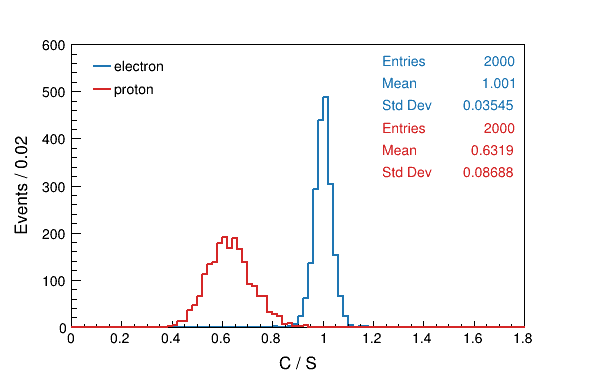

In [16]:
c6 = ROOT.TCanvas("c6", "c6", 600, 400)
ROOT.gPad.SetLeftMargin(0.12)
ROOT.gPad.SetBottomMargin(0.12)
ROOT.gPad.SetRightMargin(0.12)
ROOT.gPad.SetTopMargin(0.12)
ROOT.gStyle.SetOptStat("emr")

model = ("","", 90, 0., 1.8)
h6_e = rdf['electron'].Histo1D(model, "CoverS")
h6_pi = rdf['proton'].Histo1D(model, "CoverS")
h6_e.SetLineColor(palette['blue'].GetNumber())
h6_pi.SetLineColor(palette['red'].GetNumber())
h6_e.Draw()
h6_pi.Draw("sames")

labelsize = 1.2 * h6_e.GetYaxis().GetLabelSize()
titlesize = 1.4 * h6_e.GetYaxis().GetTitleSize()
xtitleoffset = 1.2 * h6_e.GetXaxis().GetTitleOffset()
ytitleoffset = 0.9 * xtitleoffset
xlabeloffset = 2 * h6_e.GetXaxis().GetLabelOffset()
ylabeloffset = 1.5 * h6_e.GetYaxis().GetLabelOffset()
linewidth = 2
ticklength = 0.02
x2ndc = 1-0.12
y2ndc = 1-0.12-0.012

h6_e.GetXaxis().SetTitle("C / S")
h6_e.GetXaxis().SetTitleSize(titlesize)
h6_e.GetXaxis().SetLabelSize(labelsize)
h6_e.GetXaxis().SetLabelOffset(xlabeloffset)
h6_e.GetXaxis().CenterTitle()
h6_e.GetXaxis().SetTitleOffset(xtitleoffset)
h6_e.GetXaxis().SetTickLength(ticklength)
binwidth = h6_e.GetBinWidth(1)
h6_e.SetAxisRange(0., 600., "Y")
h6_e.GetYaxis().SetTitle(f"Events / {binwidth}")
h6_e.GetYaxis().SetTitleSize(titlesize)
h6_e.GetYaxis().SetLabelSize(labelsize)
h6_e.GetYaxis().SetLabelOffset(ylabeloffset)
h6_e.GetYaxis().CenterTitle()
h6_e.GetYaxis().SetTitleOffset(ytitleoffset)
h6_e.GetYaxis().SetTickLength(ticklength)

h6_e.SetLineWidth(linewidth)
h6_pi.SetLineWidth(linewidth)

c6.Update()

# stat box
stats1 = h6_e.GetListOfFunctions().FindObject("stats")
h6_e.GetListOfFunctions().Remove(stats1)
h6_e.SetStats(0)
stats1.SetTextColor(palette['blue'].GetNumber())

stats1.SetX2NDC(x2ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetX1NDC(stats1.GetX2NDC()-0.25)
stats1.SetY1NDC(stats1.GetY2NDC()-0.12*6/4)
stats1.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
h6_e.SetStats(0)

stats2 = h6_pi.GetListOfFunctions().FindObject("stats")
h6_pi.GetListOfFunctions().Remove(stats2)
h6_pi.SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.12*6/4)
stats2.SetTextSize(labelsize)
stats2.SetBorderSize(0)
stats2.Draw()
h6_pi.SetStats(0)

# add legend
legend = ROOT.TLegend(0.12+0.03, 1-0.12-0.03, 0.32, 1-0.12-0.15)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(h6_e.GetValue(), "electron", "l")
legend.AddEntry(h6_pi.GetValue(), "proton", "l")
legend.Draw()

c6.Draw()
c6.SaveAs('pid.png')

In [11]:
nentries = h6_e.GetNbinsX()
for i in range(int(nentries/2), nentries+1):
    if h6_e.Integral(i, nentries) != 0 and h6_pi.Integral(i, nentries):
        electron_efficiency = h6_e.Integral(i, nentries) / h6_e.Integral(1, nentries)
        pion_rejection_factor = h6_pi.Integral(0, i-1) / h6_pi.Integral(i, nentries)
        lowerEdge = h6_e.GetXaxis().GetBinLowEdge(i)
        print(i, f"{lowerEdge:.2f}", electron_efficiency, pion_rejection_factor)

45 0.88 0.999 332.3333333333333
46 0.90 0.9955 499.0
47 0.92 0.984 665.6666666666666


## 3. Shower profiles

In [23]:
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/module"

In [24]:
getNij_code = '''
using namespace ROOT::VecOps;
RVec<int> getNi(RVec<int> v, int voxelsAlongY) {
    return v / voxelsAlongY;
};
RVec<int> getNj(RVec<int> v, int voxelsAlongY) {
    return v % voxelsAlongY;
};
'''
ROOT.gInterpreter.Declare(getNij_code)

True

In [25]:
getRadialDistance_code = '''
using namespace ROOT::VecOps;
RVec<double> getRadialDistance(const RVec<double> &x, const RVec<double> &y)
{ 
  auto mod = [](double x, double y) { return sqrt(x * x + y * y); };
  return Map(x, y, mod);
}
'''
ROOT.gInterpreter.Declare(getRadialDistance_code)

True

In [26]:
getArange_code ='''
using namespace ROOT::VecOps;
RVec<int> getArange(const int& a)
{ 
  RVec<int> v(a);
  std::iota(std::begin(v), std::end(v), 0);
  return v;
}
'''
ROOT.gInterpreter.Declare(getArange_code)

True

In [27]:
getRadialProfile_code ='''
using namespace ROOT::VecOps;
RVec<double> getRadialProfile(const RVec<double> &r, const RVec<double> &v1, const RVec<double> &xbins)
{
  double v2 = 0.;
  RVec<double> v(xbins.size());
  RVec<bool> c;
  RVec<double> if_c_v1_else_v2;
  for (size_t i = 0; i<xbins.size()-1; ++i) { 
    c = (r >= xbins.at(i)) && (r < xbins.at(i+1));
    if_c_v1_else_v2 = Where(c, v1, v2);
    v.at(i) = Sum(if_c_v1_else_v2);
  }
  return v;
}
'''
ROOT.gInterpreter.Declare(getRadialProfile_code)

True

In [28]:
# create dataframes
treeName = "B4"
rdf_profile = dict()
for s in ['10GeV', '40GeV']:
    fileName = os.path.join(path, f"{s}/{s}.root")
    rdf_profile[s] = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
    # define new columns
    rdf_profile[s] = rdf_profile[s].Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
    rdf_profile[s] = rdf_profile[s].Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))

In [29]:
for s, v in zip(['10GeV', '40GeV'], ["Scnt", "Ckov"]):
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_i", f"getNi(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_j", f"getNj(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_x", f"{v}_j-VecShower{v}CoMj.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_y", f"{v}_i-VecShower{v}CoMi.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"VecSignal{v}_corr/Sum(VecSignal{v}_corr)")    
#     rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"RVec<double>(VecSignal{v})/Sum(VecSignal{v})")    
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_r_mm", f"1.5*getRadialDistance({v}_x, {v}_y)")

In [30]:
binwidth = 0.6
xlow = 0.
xup = 1.5*np.sqrt(2*8**2)
nbins = int(np.ceil((xup-xlow)/binwidth))
xup = nbins*binwidth
print(nbins, xlow, xup)

29 0.0 17.4


Normalized signal INCLUDING under and overflow

The signal is leakage corrected (normalization makes calibration void)

The radial distance ($r_i$) between each individual fiber 𝑖 and the
shower axis was then determined as Eq. 3 Antonello2018

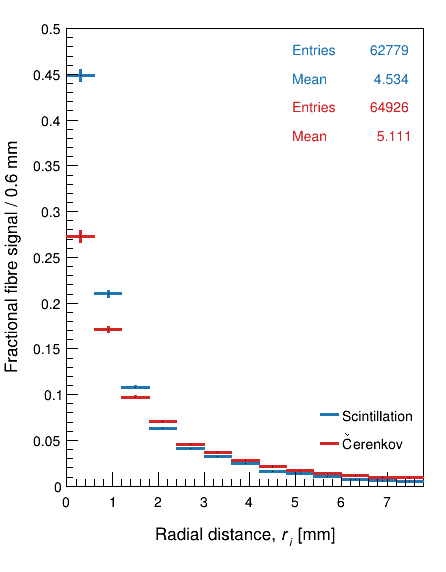

In [42]:
c8 = ROOT.TCanvas("c8", "c8", 450, 600)
ROOT.gStyle.SetOptStat("em")
x = ["Scnt_r_mm", "Ckov_r_mm"]
y = ["Scnt_norm", "Ckov_norm"]
p = [None, None]
model = ("", "", nbins, xlow, xup)
p[0] = rdf_profile['10GeV'].Profile1D(model, x[0], y[0])
p[1] = rdf_profile['40GeV'].Profile1D(model, x[1], y[1])
p[0].Draw()
p[1].Draw("sames")

#
p[0].SetLineColor(palette['blue'].GetNumber())
p[1].SetLineColor(palette['red'].GetNumber())
p[0].GetXaxis().SetTitle("Radial distance, #it{r_{i}} [mm]")
p[0].GetXaxis().SetRangeUser(0., 7.8)
p[0].GetYaxis().SetTitle(f"Fractional fibre signal / {binwidth} mm")
p[0].SetAxisRange(0., 0.5, "Y")

#
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetRightMargin(0.05)
ROOT.gPad.SetTopMargin(0.05)

labelsize = 1 * p[0].GetYaxis().GetLabelSize()
titlesize = 1.2 * p[0].GetYaxis().GetTitleSize()
xtitleoffset = 1.3 * p[0].GetXaxis().GetTitleOffset()
ytitleoffset = 1.4 * xtitleoffset
xlabeloffset = 2 * p[0].GetXaxis().GetLabelOffset()
ylabeloffset = 2 * p[0].GetYaxis().GetLabelOffset()
linewidth = 3
# x2ndc = 0.89+0.08
# y2ndc = 0.88+0.05

ticklength = 0.02
x2ndc = 1-0.05-0.01
y2ndc = 1-0.05-0.012

p[0].SetLineWidth(linewidth)
p[1].SetLineWidth(linewidth)

p[0].GetXaxis().SetTitleSize(titlesize)
p[0].GetXaxis().SetLabelSize(labelsize)
p[0].GetXaxis().CenterTitle()
p[0].GetXaxis().SetTitleOffset(xtitleoffset)
p[0].GetXaxis().SetLabelOffset(xlabeloffset)

p[0].GetYaxis().SetTitleSize(titlesize)
p[0].GetYaxis().SetLabelSize(labelsize)
p[0].GetYaxis().CenterTitle()
p[0].GetYaxis().SetTitleOffset(ytitleoffset)
p[0].GetYaxis().SetLabelOffset(ylabeloffset)

c8.Update()

# stat box
stats1 = p[0].GetListOfFunctions().FindObject("stats")
p[0].GetListOfFunctions().Remove(stats1)
p[0].SetStats(0)
stats1.GetLineWith("Mean y").SetTextColor(0)
stats1.SetTextColor(palette['blue'].GetNumber())
stats1.SetX2NDC(x2ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetX1NDC(stats1.GetX2NDC()-0.3)
stats1.SetY1NDC(stats1.GetY2NDC()-0.1)
stats1.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
p[0].SetStats(0)

stats2 = p[1].GetListOfFunctions().FindObject("stats")
p[1].GetListOfFunctions().Remove(stats2)
p[1].SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.1)
stats2.SetTextSize(labelsize)
stats2.SetBorderSize(0)
stats2.GetListOfLines().Remove(stats2.GetLineWith("Mean y"))
stats2.Draw()
p[1].SetStats(0)

# legend
legend = ROOT.TLegend(stats1.GetX1NDC()+0.07, 0.2, stats1.GetX2NDC(), 0.3)
legend.SetFillColor(0)
#legend.SetTextAlign(ROOT.kHAlignLeft+ROOT.kVAlignTop)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(p[0].GetValue(), "Scintillation", "l")
legend.AddEntry(p[1].GetValue(), "#check{C}erenkov", "l")
legend.Draw()

c8.Modified()

c8.Update()
c8.Draw()
c8.SaveAs("LateralProfile.png")